**YoloV4 with Open CV**
# Import Libraries

In [1]:
import numpy as np
import cv2 as cv2
import os
import time

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Routine to fix colors in image
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Read the names files

In [2]:
labelsFile="model_data/yolo_coco.names"
LABELS = open(labelsFile).read().strip().split("\n")
print ("No. of supported classes", len(LABELS))

No. of supported classes 80


Create an array with unique colors for each class

In [3]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

# Model
Download the model and save it the directory model_data

In [17]:
!wget -q https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights -O model_data/yolov4.weights

Read the model config and weights files using the readNetFromDarknet method in the CopenCV DNN module

In [4]:
weights="model_data/yolov4.weights"
config="model_data/yolov4.cfg"
net = cv2.dnn.readNetFromDarknet(config, weights)

Let us take a look at all the layers in the model. As you will there a total of 379 layers. They convolution layers, batch normalisations and mish activations.

In [5]:
#Take a look at names of all layers in the model
ln = net.getLayerNames()
print (len(ln), ln )



379 ['conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5', 'bn_5', 'mish_6', 'conv_6', 'bn_6', 'mish_7', 'shortcut_7', 'conv_8', 'bn_8', 'mish_9', 'concat_9', 'conv_10', 'bn_10', 'mish_11', 'conv_11', 'bn_11', 'mish_12', 'conv_12', 'bn_12', 'mish_13', 'identity_13', 'conv_14', 'bn_14', 'mish_15', 'conv_15', 'bn_15', 'mish_16', 'conv_16', 'bn_16', 'mish_17', 'shortcut_17', 'conv_18', 'bn_18', 'mish_19', 'conv_19', 'bn_19', 'mish_20', 'shortcut_20', 'conv_21', 'bn_21', 'mish_22', 'concat_22', 'conv_23', 'bn_23', 'mish_24', 'conv_24', 'bn_24', 'mish_25', 'conv_25', 'bn_25', 'mish_26', 'identity_26', 'conv_27', 'bn_27', 'mish_28', 'conv_28', 'bn_28', 'mish_29', 'conv_29', 'bn_29', 'mish_30', 'shortcut_30', 'conv_31', 'bn_31', 'mish_32', 'conv_32', 'bn_32', 'mish_33', 'shortcut_33', 'conv_34', 'bn_34', 'mish_35', 'conv_35', 'bn_35', 'mish_36', 'shortcut_36', 'conv_37', 'bn_37', 'mish_38', 'conv_38', 'bn_38', '

We will determine the output layers. The output layers are the last layers and therefore their output connections are open and unconnected.

In [6]:
net.getUnconnectedOutLayers()

array([[327],
       [353],
       [379]], dtype=int32)

In [7]:
# determine only the *output* layer names that we need from YOLO

ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print (ln)

['yolo_139', 'yolo_150', 'yolo_161']


# The Image
We will read the image using an OpenCV method. We will resize it for making it eeasier to be viewed.

(608, 608, 3)


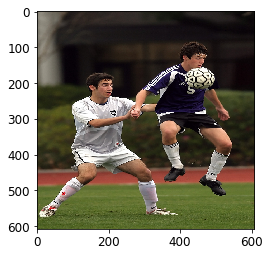

In [24]:
img=cv2.imread("images/soccer.jpg")
img=cv2.resize(img, (608, 608))
plt.imshow(fixColor(img))
print (img.shape)
(H, W) = img.shape[:2]

We will make it into a blob which is a 4 dimensional array of images. We also do the following steps
1. Normalising pixel values by dividing by 255
2. Fixing the size to 608x608 required by Yolo
3. Swapping openCVs default BGR format to RGB

In [9]:
blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (608, 608), swapRB=True, crop=False)

In [10]:
print ("Shape of blob", blob.shape)

Shape of blob (1, 3, 608, 608)


We can see the individual color streams of the image

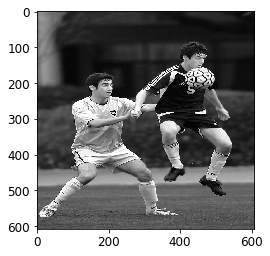

In [11]:
plt.imshow(fixColor(blob[0, 0, :, :]))

We can see all the 3 color streams in one picture using the following step

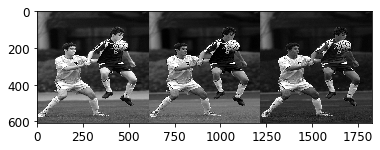

In [12]:
split_blob=np.hstack([ blob[0, 0, :, :],blob[0, 1, :, :], blob[0, 2, :, :],])
plt.imshow(fixColor(split_blob))

# Inference

In this section we will apply the model on the image.

In [13]:
net.setInput(blob)

The next step is the inference step. We will take output of the output layers only.

In [14]:
t0 = time.time()
layerOutputs = net.forward(ln)
t = time.time()
print('time=', t-t0)
(np.array(layerOutputs)).shape

time= 1.2236511707305908


(3,)

# Post Processing

The YOLO network has 3 outputs:

- 1083 (19 x 19 x 3) for large objects
- 4332 (38 x 38 x 3) for medium objects
- 17328 (76 x 76 x 3) for small objects

Below we see the each output has given us predictions at different scales.

In [15]:
print (len(layerOutputs))

3


The first layer has 17328 predictions, 3 predictions for each 19x19 grid.

In [20]:
print (len(layerOutputs[0]))

17328


Each prediction has a bounding box with 4 coordinates, 1 objectiveness score and 80 predictions confidences

In [21]:
print (len(layerOutputs[0][0]))

85


In [23]:
print (layerOutputs[0][0])

[5.7796203e-03 6.1123236e-03 1.3216493e-02 1.4507842e-02 7.2515948e-05
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

We will first collect all valid predictions i.e. wherever confidence score is higher than the threshold. We will collect the box coordinates, confidences and classIDs.

In [25]:
boxes = []
confidences = []
classIDs = []


We will iterate through all the outputs in the layerOutputs (3); each detection in the output (17328, 4332, 1083). So we go through a total of 22743 pedictions and collect valid predictions

In [29]:
for output in layerOutputs:
    print ("Shape of each output", output.shape)
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence (i.e., probability)
        # of the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > 0.3:
            # scale the bounding box coordinates back relative to
            # the size of the image, keeping in mind that YOLO
            # actually returns the center (x, y)-coordinates of
            # the bounding box followed by the boxes' width and
            # height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)-coordinates to derive the top
            # and and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates,
            # confidences, and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)
            print (LABELS[classID], detection[4], confidence)




Shape of each output (17328, 85)
sports ball 0.9116492 0.90988046
sports ball 0.93582696 0.9307697
Shape of each output (4332, 85)
sports ball 0.9963799 0.99579364
sports ball 0.99670726 0.9954545
sports ball 0.9961105 0.99263036
Shape of each output (1083, 85)
sports ball 0.9960573 0.99452233
person 0.9149836 0.9148787
person 0.9186291 0.9185599
person 0.9891433 0.9891228
person 0.98990065 0.9898779
person 0.5279726 0.5277281
person 0.55256116 0.55226564
person 0.8187046 0.81856424
person 0.78427434 0.78412884
person 0.9692143 0.9690731
person 0.96856123 0.968457
person 0.978408 0.9783869
person 0.98149246 0.98147
person 0.5947928 0.5946748
person 0.5611462 0.56101215
person 0.36454174 0.3641918
person 0.45565358 0.4552634
person 0.77969605 0.77929246
person 0.7788326 0.7784597


In [27]:
print (len(boxes))

24


There are a total 24 valid predictions. Some of these predictions are overlapping. They are filtered using NMS (Non maxima suppression). It takes an IoU threshold and a confidence threshold.

In [31]:
# apply non-maxima suppression to suppress weak, overlapping
# bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
print (len(idxs))

3


We will then iterate through these predictions to get the boxes and confidences and put them on our image

In [32]:
# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])

		# draw a bounding box rectangle and label on the frame
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]],
			confidences[i])
		cv2.putText(img, text, (x, y - 5),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

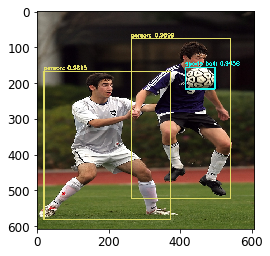

In [33]:
plt.imshow(fixColor(img))

In [24]:
cv2.imwrite("soccer_yolo_detected.png", img)

True